In [22]:
# import h2o lib and allow it to use max. threads
library(h2o)
h2o.init(nthreads = -1)


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T//RtmpjNm2kZ/h2o_phall_started_from_r.out
    /var/folders/tc/0ss1l73113j3wdyjsxmy1j2r0000gn/T//RtmpjNm2kZ/h2o_phall_started_from_r.err


Starting H2O JVM and connecting: .. Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 seconds 931 milliseconds 
    H2O cluster version:        3.12.0.1 
    H2O cluster version age:    29 days  
    H2O cluster name:           H2O_started_from_R_phall_pzf065 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   3.56 GB 
    H2O cluster total cores:    8 
    H2O cluster allowed cores:  8 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    R Version:                  R version 3.3.2 (2016-10-31) 

In [23]:
# location of clean data file
path <- "/Users/phall/Documents/aetna/share/data/loan.csv"

In [24]:
# import file
frame <- h2o.importFile(path)

# strings automatically parsed as enums (categorical)
# numbers automatically parsed as numeric
# bad_loan is numeric, but categorical
frame$bad_loan <- as.factor(frame$bad_loan)

  |======================================================================| 100%


In [25]:
# summarize table
# decision tree ensembles can run on missing values
h2o.describe(frame)

Label,Type,Missing,Zeros,PosInf,NegInf,Min,Max,Mean,Sigma,Cardinality
loan_amnt,int,0,0,0,0,500.00,35000.00,1.307417e+04,7.993556e+03,NA
term,enum,0,129950,0,0,0.00,1.00,2.075591e-01,4.055605e-01,2
int_rate,real,0,0,0,0,5.42,26.06,1.371590e+01,4.391940e+00,NA
emp_length,int,5804,14248,0,0,0.00,10.00,5.684353e+00,3.610664e+00,NA
home_ownership,enum,0,1,0,0,0.00,5.00,NA,NA,6
annual_inc,real,4,0,0,0,1896.00,7141778.00,7.191567e+04,5.907092e+04,NA
purpose,enum,0,2842,0,0,0.00,13.00,NA,NA,14
addr_state,enum,0,413,0,0,0.00,49.00,NA,NA,50
dti,real,0,270,0,0,0.00,39.99,1.588153e+01,7.587668e+00,NA
delinq_2yrs,int,29,139459,0,0,0.00,29.00,2.273570e-01,6.941679e-01,NA


In [26]:
# assign target and inputs
y <- 'bad_loan'
X <- names(frame)[names(frame) != y]
print(y)
print(X)

[1] "bad_loan"
 [1] "loan_amnt"             "term"                  "int_rate"             
 [4] "emp_length"            "home_ownership"        "annual_inc"           
 [7] "purpose"               "addr_state"            "dti"                  
[10] "delinq_2yrs"           "revol_util"            "total_acc"            
[13] "longest_credit_length" "verification_status"  


In [27]:
# split into training and valid
split <- h2o.splitFrame(frame, ratios = 0.7)
train <- split[[1]]
valid <- split[[2]]

In [28]:
# random forest
# random forest is often the best guess model with little tuning

# train
loan_rf <- h2o.randomForest(
    x = X,
    y = y,
    training_frame = train,
    validation_frame = valid,
    ntrees = 500,                      # Up to 500 decision trees in the forest 
    max_depth = 30,                    # trees can grow to depth of 30
    stopping_rounds = 2,               # stop after validation error does not decrease for 5 iterations/new trees
    score_each_iteration = TRUE,       # score validation error on every iteration/new tree
    model_id = "loan_rf")              # for easy lookup in flow

# print model information
loan_rf

# view detailed results at http://ip:port/flow/index.html

  |======================================================================| 100%


Model Details:

H2OBinomialModel: drf
Model ID:  loan_rf 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1              76                       76            15536744        30
  max_depth mean_depth min_leaves max_leaves mean_leaves
1        30   30.00000      14307      15595 15031.52600


H2OBinomialMetrics: drf
** Reported on training data. **
** Metrics reported on Out-Of-Bag training samples **

MSE:  0.1424317
RMSE:  0.3774012
LogLoss:  0.5384553
Mean Per-Class Error:  0.3747821
AUC:  0.6711422
Gini:  0.3422843

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
           0     1    Error           Rate
0      60494 33346 0.355350   =33346/93840
1       8245 12670 0.394215    =8245/20915
Totals 68739 46016 0.362433  =41591/114755

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold    value idx
1                       max f1  0.204672 0.378599 249
2     

In [29]:
# GBM with random hyperparameter search
# GBM often more accurate than random forest but requires some tuning

# define random grid search parameters
ntrees_opts = seq(100, 500, 50)
max_depth_opts = seq(2, 20, 2)
sample_rate_opts = seq(0.1, 0.9, 0.1)
col_sample_rate_opts = seq(0.1, 0.9, 0.1)

hyper_params = list(ntrees = ntrees_opts,
                    max_depth = max_depth_opts,
                    sample_rate = sample_rate_opts,
                    col_sample_rate = col_sample_rate_opts)

# search a random subset of these hyper-parmameters
# max runtime and max models are enforced
# and the search will stop after not improving much over the best 5 random models
search_criteria = list(strategy = "RandomDiscrete", 
                       max_runtime_secs = 600, 
                       max_models = 20, 
                       stopping_metric = "AUC", 
                       stopping_tolerance = 0.0001, 
                       stopping_rounds = 5, 
                       seed = 12345)

# execute training w/ grid search
loan_gbm <- h2o.grid("gbm", 
                     grid_id = "gbm_grid",
                     x = X, 
                     y = y, 
                     training_frame = train,
                     validation_frame = valid,
                     
                     # per model stopping criteria 
                     stopping_rounds = 2,
                     stopping_tolerance = 1e-3,
                     stopping_metric = "AUC",
                     
                     # how often to score (affects early stopping, training speed)
                     score_tree_interval = 5, 
                     
                     # seed to control sampling 
                     seed = 12345,
                     # grid serach options
                     hyper_params = hyper_params,
                     search_criteria = search_criteria)

# view detailed results at http://ip:port/flow/index.html

  |======================================================================| 100%


In [32]:
# show grid results
sorted_grid <- h2o.getGrid(grid_id = "gbm_grid")
print(sorted_grid)

H2O Grid Details

Grid ID: gbm_grid 
Used hyper parameters: 
  -  col_sample_rate 
  -  max_depth 
  -  ntrees 
  -  sample_rate 
Number of models: 20 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by increasing logloss
   col_sample_rate max_depth ntrees sample_rate         model_ids
1              0.3         4    350         0.4  gbm_grid_model_9
2              0.6         6    100         0.6 gbm_grid_model_16
3              0.3         4    150         0.1 gbm_grid_model_17
4              0.4         2    250         0.7  gbm_grid_model_0
5              0.1         2    350         0.6 gbm_grid_model_13
6              0.4        10    400         0.6  gbm_grid_model_1
7              0.8        10    400         0.6  gbm_grid_model_5
8              0.1        10    500         0.1  gbm_grid_model_7
9              0.2        14    250         0.8  gbm_grid_model_4
10             0.5        12    250         0.7 gbm_grid_model_19
11             0.9        12   

In [33]:
# select best model
best_model <- h2o.getModel(sorted_grid@model_ids[[1]])
summary(best_model)

Model Details:

H2OBinomialModel: gbm
Model Key:  gbm_grid_model_9 
Model Summary: 
  number_of_trees number_of_internal_trees model_size_in_bytes min_depth
1              70                       70               48112         4
  max_depth mean_depth min_leaves max_leaves mean_leaves
1         4    4.00000          9         16    15.00000

H2OBinomialMetrics: gbm
** Reported on training data. **

MSE:  0.1348012
RMSE:  0.3671529
LogLoss:  0.4281231
Mean Per-Class Error:  0.34324
AUC:  0.7193566
Gini:  0.4387132

Confusion Matrix (vertical: actual; across: predicted) for F1-optimal threshold:
           0     1    Error           Rate
0      67199 26641 0.283898   =26641/93840
1       8420 12495 0.402582    =8420/20915
Totals 75619 39136 0.305529  =35061/114755

Maximum Metrics: Maximum metrics at their respective thresholds
                        metric threshold    value idx
1                       max f1  0.206819 0.416146 220
2                       max f2  0.114905 0.571406 309

In [34]:
# use variable importance to get insight into important relationships
h2o.varimp(best_model)

variable,relative_importance,scaled_importance,percentage
int_rate,2620.247559,1.00000000,0.451129917
term,645.164246,0.24622263,0.111078395
addr_state,598.834900,0.22854134,0.103101838
annual_inc,558.047546,0.21297512,0.096079450
dti,341.925201,0.13049347,0.058869509
revol_util,334.958801,0.12783479,0.057670099
purpose,257.972839,0.09845361,0.044415370
loan_amnt,168.724228,0.06439248,0.029049372
emp_length,74.849014,0.02856563,0.012886809
total_acc,68.440407,0.02611982,0.011783434


  |======================================================================| 100%


int_rate,mean_response,stddev_response
5.420000,0.07635569,0.04293206
6.506316,0.07635569,0.04293206
7.592632,0.09022306,0.04889183
8.678947,0.10956080,0.05369815
9.765263,0.12255792,0.05438731
10.851579,0.13442127,0.05985479
11.937895,0.14375390,0.06150664
13.024211,0.16183460,0.06246395
14.110526,0.18350078,0.06645215
15.196842,0.19332465,0.06996814


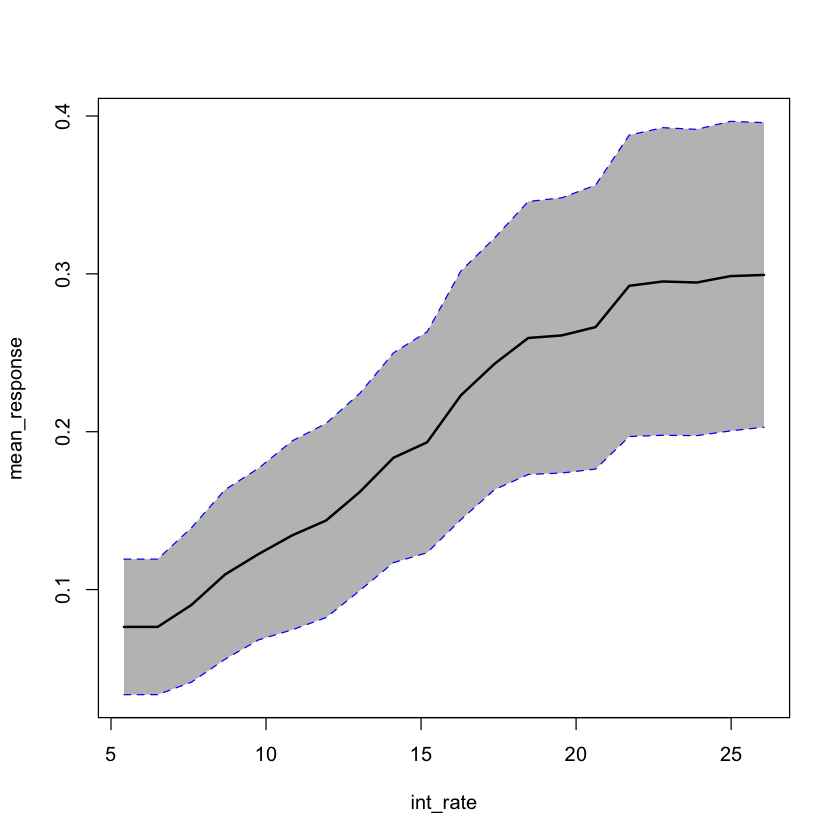

In [35]:
# use partial dependence plots to get insight into important relationships
h2o.partialPlot(best_model, valid, "int_rate")

In [36]:
h2o.shutdown(prompt = FALSE)

[1] TRUE